In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Covid-19 Task: SARS-COV-2 genome analysis.
- Building a mutation profile (matrix rows: patients, columns: mutations).

- Generation of a network of similarities between mutations for each clade present in at least 1000 records.

- Generation of networks (for each clade) representing sets of frequently similar mutations (a triple of mutations which are always connected to others four).

- For each pair of clades, I calculate the similarity between clusters of frequently similar mutations, in order to study the tendency with which these clusters appear from variant to variant.

## Step 1: data acquisition
### Dask e Pandas
Given that each file of the dataset consists of a table with thousands of rows and columns, I thought of developing the project using the <b>pyspark</b> library, however the the pyspark.read.csv() function caused mismatches between the columns and their values.

For this reason, I decided to use the pandas library which manages to acquire the matrices correctly.
Since we are dealing with very large matrices in the order of gigabytes, in many cases pandas also fails, so for this reason I decided to use <b>Dask</b> which allows to adapt pandas and other python libraries to parallel calculation on multiple CPUs.

Dask maintains a familiar interface with pandas one, so it supports all its most important functions used in data analysis.

In [ ]:
import pandas as pd
import dask.dataframe as dd

# Dask like Apache Spark has a Client on which it is possible to visualize
# various information regarding the running or completed tasks. Using it is optional.

#from distributed import Client
#client = Client()
import warnings
warnings.filterwarnings('ignore')

## Dataset Description:
Each dataset file contains a matrix where each row corresponds to a patient affected by COVID-19 and each column contains various parameters relating to the sample collected, in particular:

- **Name** (String): sample name
- **Accession** (String): missing info
- **Geo_Location** (String): geographical position where the sample was collected.
- **Country** (String): country where the sample was collected.
- **Collection_Date** (Date): sample collection date.
- **Host** (String): species of the host on which the sample was collected (man...etc)
- **Isolation_Source** (String): pickup method.
- **clade** (String): sample virus covid variant (Omicron, 20A, etc...)
- [E.__76...- S.Y904H] (Int): series of binary columns with binary values 0/1 indicating the absence/presence of the particular mutation named by the name of the column.

I loaded all the files of the input dataset (one at a time for memory reasons) into a dataframe dask and saved for each of these a csv file containing the number of records that belongs to it for each different clade observed.

In [ ]:
# creating the dataframe with the matrix denoted by the path
import glob
df = dd.read_table('/content/drive/MyDrive/BigData/matrici_binaria_mutazioni_ncbi_info/matrice_binaria_mutazioni_ncbi_sars9_info.txt')
df.head()
#df.tail()
#df.npartitions
#df.partitions[0]

,Name,Accession,Geo_Location,Country,Collection_Date,Host,Isolation_Source,clade,month,E.C40F,...,S.Y144V,S.Y145.,S.Y145D,S.Y145S,S.Y170H,S.Y248.,S.Y248H,S.Y248N,S.Y505F,S.Y505H
1,ncbi_sars90,ON627466,Bahrain,Bahrain,2022-05-15,Homo sapiens,NaN,21L(Omicron),ncbi_sars,0,...,0,0,0,0,0,0,0,0,0,1
2,ncbi_sars900,ON625242,USA: New Jersey,USA,2022-05-13,Homo sapiens,oronasopharynx,21L(Omicron),ncbi_sars,0,...,0,0,0,0,0,0,0,0,0,1
3,ncbi_sars9000,ON573687,USA: RI,USA,2022-04-23,Homo sapiens,NaN,21L(Omicron),ncbi_sars,0,...,0,0,0,0,0,0,0,0,0,1
4,ncbi_sars90000,ON369125,USA: North Carolina,USA,2022-04-20,Homo sapiens,NaN,21L(Omicron),ncbi_sars,0,...,0,0,0,0,0,0,0,0,0,1
5,ncbi_sars900000,MZ295552,USA: Minnesota,USA,2021-05-05,Homo sapiens,NaN,"20I(Alpha,V1)",ncbi_sars,0,...,0,0,0,0,0,0,0,0,0,0


## Step 2: Grouping records by the "clade" attribute (covid variant)
Using the <b>groupby()</b> function I grouped the dataframe records based on the values of the clade attribute which indicates the particular Covid variant observed in the sample.
Then I saved a table that indicates for each variant the number of records observed (obtained through the <b>count()</b> function).


In [ ]:
df_count = df.groupby('clade').count()

In [ ]:
df_count.head(10)

,Name,Accession,Geo_Location,Country,Collection_Date,Host,Isolation_Source,month,E.C40F,E.C43Y,...,S.Y144V,S.Y145.,S.Y145D,S.Y145S,S.Y170H,S.Y248.,S.Y248H,S.Y248N,S.Y505F,S.Y505H
clade,,,,,,,,,,,,,,,,,,,,,
19B,6,6,6,6,6,6,3,6,6,6,...,6,6,6,6,6,6,6,6,6,6
20A,90,90,90,90,90,90,35,90,90,90,...,90,90,90,90,90,90,90,90,90,90
20B,16,16,16,16,16,16,9,16,16,16,...,16,16,16,16,16,16,16,16,16,16
20C,124,124,124,124,124,124,50,124,124,124,...,124,124,124,124,124,124,124,124,124,124
20D,2,2,2,2,2,2,1,2,2,2,...,2,2,2,2,2,2,2,2,2,2
20E(EU1),1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20G,28,28,28,28,28,28,12,28,28,28,...,28,28,28,28,28,28,28,28,28,28
"20H(Beta,V2)",10,10,10,10,10,10,2,10,10,10,...,10,10,10,10,10,10,10,10,10,10
"20I(Alpha,V1)",2724,2724,2724,2724,2724,2724,987,2724,2724,2724,...,2724,2724,2724,2724,2724,2724,2724,2724,2724,2724


In [ ]:
# converting the dask dataframe into a pandas df
new_df = df_count.compute()

In [ ]:
# extract the column attribute names
column = []
for index, _ in new_df.items():
    column.append(index)

I removed all the columns except the one that refers to the clade, in order to simplify the table.

In [ ]:
columns_to_del = column[1::]
new_df.drop(columns_to_del, axis = 1, inplace=True)

In [ ]:
new_df.head(20)

,Name
clade,
19B,6
20A,90
20B,16
20C,124
20D,2
20E(EU1),1
20G,28
"20H(Beta,V2)",10
"20I(Alpha,V1)",2724


Above we have an example of the resulting table. I saved it in the format [clade: number of records] per-each different file.

In [ ]:
file_name = "/content/drive/MyDrive/BigData/clade/cladeCounter_file39.csv"
new_df.to_csv(file_name)

## Step 3: Filtering the clades which are present in a least 1000 records.
In this step I iterate all the tables created previously and concatenate them into a single matrix. In particular, the elements that belong to the same clade are summed while adding a new row if the clade is not present yet.

Once I have obtained the final dataframe I will filter the variants present in at least n = 1000 records.

In [ ]:
import glob

path = '/content/drive/MyDrive/BigData/clade/'
files = glob.glob(path+'*.csv')
df_list = []
for f in files:
  df = pd.read_table(f, sep=',')
  df_list.append(df)
clade_df = pd.concat(df_list)

In [ ]:
clade_df.head(10)

,clade,Name
0,19A,34
1,20B,194
2,21K(Omicron),139
3,21L(Omicron),69552
4,20A,9
5,21M(Omicron),15
6,21J(Delta),12
7,19B,1
0,19B,51
1,20A,682


In [ ]:
# summing all the records of the same clade
clade_s_df = clade_df.groupby('clade').sum()
clade_s_df # final df

,Name
clade,
19A,2731
19B,1261
20A,39858
20B,36449
20C,19870
20D,2232
20E(EU1),39566
20F,6
20G,33706


Above the final dataframe clade: number of observed records that belongs to the corresponding clade.

Then I filtered the clades where the number of occurences is greater or equal to 1000.

In [ ]:
filtered_c_df = clade_s_df[clade_s_df['Name'] >= 1000]
filtered_c_df

,Name
clade,
19A,2731
19B,1261
20A,39858
20B,36449
20C,19870
20D,2232
20E(EU1),39566
20G,33706
"20I(Alpha,V1)",188224


In [ ]:
# I created a list that contains the clade names that passed the filtering phase
clades = list(filtered_c_df.index)
clades

['19A',
 '19B',
 '20A',
 '20B',
 '20C',
 '20D',
 '20E(EU1)',
 '20G',
 '20I(Alpha,V1)',
 '20J(Gamma,V3)',
 '21A(Delta)',
 '21C(Epsilon)',
 '21F(Iota)',
 '21I(Delta)',
 '21J(Delta)',
 '21K(Omicron)',
 '21L(Omicron)']

In total I found **17 clades** that pass the filter.

Then I created a list that represents the union of all the mutations present in the various variants. I will need this list in the next phase in order to create the mutation/patient dictionaries.

In [ ]:
# I created a list that represents the union of all the mutations present in each files of the dataset.
# Iterating all over the files of the dataset, adding in "mut" those that are not present yet.
mut = []

path = '/content/drive/MyDrive/BigData/matrici_binaria_mutazioni_ncbi_info/matrice_binaria_mutazioni_ncbi_sars9_info.txt'
df = dd.read_table(path)
columns = list(df.columns)
col = columns[8::]

for m in col:
  if(not(m in mut)):
    mut.append(m)
print(len(col), len(mut))

In [ ]:
# saving the total list of mutations in a file
import csv
with open('total_mutation.csv', 'a')as w:
  writer = csv.writer(w)
  for m in mut:
    data = [m]
    writer.writerow(data)

In [ ]:
import csv
# I load all the mutation names present in the dataset
mut = []
with open('/content/drive/MyDrive/BigData/matrici_clade/total_mutation.csv', 'r')as r:
  for mu in csv.reader(r):
    mut.append(mu[0])

print(len(mut), len(mut))

40144 40144


Before of the next phase I splitted some files of the dataset into smaller ones as they were too large in size and therefore caused RAM problems.

In [ ]:
filename = '/content/drive/MyDrive/BigData/matrici_binaria_mutazioni_ncbi_info/fatte/matrice_binaria_mutazioni_ncbi_res_84_info.txt'
path_err = '/content/drive/MyDrive/BigData/matrici_binaria_mutazioni_ncbi_info/matrice_binaria_mutazioni_june_22_info.txt'
v = clades[15]
df = dd.read_table(filename)
if(f == path_err): df = df.iloc[:,1:]
f_df = (df[df['clade'] == v])

l = len(f_df)

In [ ]:
index = int(l/2)
f_df = f_df.compute()
df1 = f_df.iloc[:index]
df2 = f_df.iloc[index:]
f = '/content/drive/MyDrive/BigData/matrici_binaria_mutazioni_ncbi_info/fatte/matrice_binaria_mutazioni_ncbi_res_84_info1.txt'
f2 = '/content/drive/MyDrive/BigData/matrici_binaria_mutazioni_ncbi_info/fatte/matrice_binaria_mutazioni_ncbi_res_84_info2.txt'
df1.to_csv(f)
df2.to_csv(f2)

## Step 4: Dictionary Creation {**Clade**: Patient-mutations}
At this point, to facilitate the next steps, I create dictionaries (one for each file of the dataframe), which for each different clade that has passed the filtering phase, contains the patients as rows and the mutations as columns.

Each binary entry for the mutation columns indicates the presence (1) of the mutation for the i-th patient in the respective variant (0 otherwise).


In [ ]:
import numpy as np

path_err = '/content/drive/MyDrive/BigData/matrici_binaria_mutazioni_ncbi_info/matrice_binaria_mutazioni_june_22_info.txt'
path = '/content/drive/MyDrive/BigData/matrici_clade/'
origin_path = '/content/drive/MyDrive/BigData/matrici_binaria_mutazioni_ncbi_info/fatte/'

# I select a clade
v = clades[16]
dest_path = path + v + '/'
files = glob.glob(origin_path+'*.txt')

# per-each file
# I use a dict where I keep track of the set (list) of values that {value} assume for each {key} mutation.
# For now I initialize each mutation like an empty list.
for f in files:
  mutation_dict = {}
  for m in mut:
    mutation_dict[m] = []

  df = dd.read_table(f)
  if(f == path_err): df = df.iloc[:,1:]

  # I select only the rows relating to the selected clade
  f_df = (df[df['clade'] == v])
  # If in the file there are records for that clade
  if(len(f_df) > 0):
    print(len(f_df))
    record_for_clade = f_df.compute()
    # I remove the columns that do not represent mutations
    record_for_clade.drop((list(record_for_clade.columns))[0:8], axis = 1, inplace=True)

    df_col = list(record_for_clade.columns)
    l = len(record_for_clade.index)

    for key in mutation_dict:
      if(key in df_col):
        lista = list(record_for_clade[key])
        for i in range(len(lista)): # I add the list of values of the c mut
          mutation_dict[key].append(lista[i])
      else:
        for i in range(l): # if there are no values for a mutation I put 0
          mutation_dict[key].append(0)
    # I save the new dict
    file_name = dest_path + f.split('/')[-1][0:-4]+'.csv'
    df_tosave = dd.from_dict(mutation_dict, npartitions=100)
    dd.to_csv(df_tosave, file_name, single_file=True)

Below I show a visual example of the new table.

In [ ]:
# visual example
es_df = pd.read_table('/content/drive/MyDrive/BigData/matrici_clade/21K(Omicron)/matrice_binaria_mutazioni_ncbi_res_81_info1.csv', sep=',')
es_df.iloc[:,1:].head()

,E..76.,E.A22V,E.A41V,E.C40F,E.C43F,E.D72G,E.E8D,E.F20L,E.F23C,E.F23L,...,ORF1a.T2069V,ORF1a.T770S,ORF1b.A1794V,ORF1b.A2504E,ORF1b.G2004C,ORF1b.S1636.,ORF1b.T1202S,ORF1b.T1637.,S.P85R,S.Y145S
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**The mutation is present in the clade if it appears in at least one patient, therefore if it takes the value 1 in at least one record of the table**.

Then I create and save into files at the path '/content/drive/MyDrive/BigData/ab-pr/' separate lists which for each clade indicate the list of present and absent mutations.

In [ ]:
import glob
import pandas as pd

#per ogni mutazione

for c in clades:
  print(c)
  path = '/content/drive/MyDrive/BigData/matrici_clade/'+c+'/'
  save_path = '/content/drive/MyDrive/BigData/ab-pr/'+c+'/'

  files = glob.glob(path+'*.csv')
  mutation_in_clade = []

  for f in files:
    print(f)
    df = pd.read_table(f, sep = ',')
    df = df.iloc[:,1:]

    name = f.split('/')[7]
    dest_path = save_path+'p_'+ name[0:-4] + '.txt'

    for m in mut:
      if(1 in df[m].values):
        if(not (m in mutation_in_clade)): mutation_in_clade.append(m)


  with open(dest_path, "w") as w:
    for v in mutation_in_clade:
      w.write(v + '\n')

In [ ]:
# I iterate the total mutations and remove the ones present for each files and get the absent ones

# for each clade
for c in clades:
  print(c)
  origin_path = '/content/drive/MyDrive/BigData/ab-pr/'+c+'/p_'+c+'.txt'
  save_path = '/content/drive/MyDrive/BigData/ab-pr/'+c+'/a_'+c+'.txt'

  mutation_in_clade = []
  ab_mut_in_clade = []

  with open(origin_path, 'r')as r:
    for line in csv.reader(r):
      mutation_in_clade.append(line[0])

  for m in mut:
    if(not (m in mutation_in_clade)):
      ab_mut_in_clade.append(m)

  with open(save_path, "w") as w:
    for v in ab_mut_in_clade:
      w.write(v + '\n')

Once I have obtained the mutations that are not present in the various clades, I create the definitive dataframes by removing the mutations that are not present and keeping only those that are present.

In [ ]:
import glob
import pandas as pd

for c in clades:
  print(c)
  origin_path = '/content/drive/MyDrive/BigData/matrici_clade/'+c+'/'
  mut_path = '/content/drive/MyDrive/BigData/ab-pr/'+c+'/a_'+c+'.txt'
  dest_path = '/content/drive/MyDrive/BigData/mutations/'+c+'/'

  # I read the absent mutations
  mut_to_remove = []
  with open(mut_path, 'r')as r:
    for row in csv.reader(r):
      mut_to_remove.append(row[0])

  # I load all the files for the clade c
  files = glob.glob(origin_path+'*.csv')

  for f in files: # for each of them
    print(f)
    file_name = f.split('/')[-1]
    # I read the df
    df = pd.read_table(f, sep=',')
    print(len(df.columns))
    df = df.iloc[:,1:] # I remove the first column

    # I remove the mutations that are not present
    df.drop(mut_to_remove, axis=1, inplace=True)
    print(len(df.columns))
    # save
    save_path = dest_path+file_name
    df.to_csv(save_path, sep=',')

## Step 5: Min-Hashing

Since the number of attributes or mutations on which calculate pairwise Jaccard similarity is very large (more than 10.000 mutations for several thousand records), I use the **Min-Hashing** algorithm to make the process faster and economical.

In short, the **min-hashing** of a data matrix consists of compressing it into a smaller one called <b>"signature"</b> where the similarity between its elements is preserved.

In theory the signature matrix is calculated by taking for each attribute the index of the first element equal to one where the rows have been premuted randomly, however in in practise generating permutations randomly is expensive.

For this reason I used the <b>Row Hashing</b> which uses hash functions instead.

Therefore, in my case the dataframe's signatures matrix will have dataframe's attributes as columns (present mutations) while the number of rows will be equal to the number of hash function used (two).

In brief:
- Initialize the signatures matrix to infinity. sign(C)[i] = inf.
- Iterate the rows looking for elements equal to 1
  - Assuming we have sign(C)[j] = 1
  - For each ki:
    - If ki(j) < sign(C)[i] then sign(C)[i] = ki(j)

In [ ]:
import sys
# create two hash functions
def h1(x):
        return (x+1)%5
def h2(x):
        return (3*x+1)%5

# Min-Hashing algorithm
def minhash(data, hashfuncs):

    rows, cols, sigrows = len(data), len(data[0]), len(hashfuncs)

    # firstly initialize the signatures matrix to infinite values
    sigmatrix = []
    for i in range(sigrows):
        sigmatrix.append([sys.maxsize] * cols)

    for r in range(rows):
        hashvalue = list(map(lambda x: x(r), hashfuncs))
        # if data != 0 and the signature > hash value, then replace the signature with the hash value
        for c in range(cols):
            if data[r][c] == 0:
                continue
            for i in range(sigrows):
                if sigmatrix[i][c] > hashvalue[i]:
                    sigmatrix[i][c] = hashvalue[i]

    return sigmatrix

In [ ]:
import pandas as pd
df = pd.read_table('/content/drive/MyDrive/BigData/mutations/21J(Delta)/matrice_binaria_mutazioni_ncbi_res_106_info.csv', sep=',').iloc[:,1:]
print(len(df.columns))

26735


In [ ]:
# For each clade, read all the matrix (some are splitted into different files due to their dimension)
# Create a big numpy matrix with the present mutations as columns and all the data as rows
# on this matrix I calculate the signatures matrix
import csv
import glob
import pandas as pd
import numpy as np

c = '21J(Delta)15'
print(c)
mut_matrix = np.empty((0, 26735), dtype=int)

origin_path = '/content/drive/MyDrive/BigData/mutations/'+c+'/'
mut_path = '/content/drive/MyDrive/BigData/ab-pr/21J(Delta)/p_21J(Delta).txt'

# load the present mutations in the clade that will be the columns of the signs matrix
mut = []
with open(mut_path, 'r')as r:
  for line in csv.reader(r):
    mut.append(line[0])

# group all the files in which clade's datas were splitted
# convert them in a numpy matrix in order to spped up calculations
files = glob.glob(origin_path+'*.csv')
for f in files:
  print(f)
  df = pd.read_table(f, sep=',').iloc[:,1:]
  if(len(df.index) > 0):
    numpy_matrix = df.to_numpy()
    print("dim before: ", mut_matrix.shape)
    mut_matrix = np.append(mut_matrix, numpy_matrix, axis=0)
    print("dim after: ", mut_matrix.shape)

# calculate the signatures matrix
sig_matrix = minhash(mut_matrix, [h1,h2])
# convert the sign matrix obtained into a pandas dataframe
sig_df = pd.DataFrame(sig_matrix, columns=mut)
# save it
save_path = '/content/drive/MyDrive/BigData/Signatures/sign_'+c+'.csv'
sig_df.to_csv(save_path, sep=',')

In [ ]:
# visual example of sign matrix
sign_matrix = pd.read_table('/content/drive/MyDrive/BigData/Signatures/sign_19B.csv', sep=',')
sign_matrix.head()

,Unnamed: 0,E.F26L,E.F4L,E.L21F,E.L37F,E.L37H,E.L37R,E.L73F,E.P71L,E.R69I,...,S.V622A,S.V622F,S.V70.,S.V70F,S.V90F,S.V991A,S.W152R,S.Y144.,S.Y248H,S.Y449H
0,0,2,4,4,0,3,2,4,0,0,...,3,2,3,0,1,0,3,1,0,0
1,1,4,0,0,2,0,4,0,0,0,...,2,4,2,3,1,0,2,1,1,1


I saved the signatures matrices for each file in  '/content/drive/MyDrive/BigData/Signatures/'

### Locality Sensitive Hashing (LSH)
The **Locality-sensitive hashing** (also known as near-neighbor search) is an algorithm that aims to find pairs of similar objects without having to analyze them all.
For this reason, in many contexts like mine case of study where I have lots of mutations in a clade, it brings a great saving in terms of memory and computational time.

Once I have obtained the signatures matrix, for each clade, I will apply the "banding" technique to calculate the similar mutations. Steps:

1.   Split the signatures matrix into bands.
2.   Calculate the hash function on each band column. Items whose hash falls into the same bucket will be similar.
3. Repeat the process for each bands. We can use the same hash function used for previous bands but in this case I have to use different buckets.

The similarity metric used to compare pairs of mutations is the **Jaccard** one, in particular a mutations pair m1 and m2 will be similar if

**J(m1, m2) >= 0.3**.

In [ ]:
import hashlib
from random import randint, seed
# the family of hash functions, in this case, is the same function (sha1) applied with a different salt.
class hashFamily:
  def __init__(self, i):
    self.resultSize = 8 # how many bytes we want back
    self.maxLen = 20 # how long can our salt be (in decimal)
    self.salt = str(i).zfill(self.maxLen)[-self.maxLen:]

  def get_hash_value(self, el_to_hash):
    return int(hashlib.sha1(str(el_to_hash).encode('utf-8') + self.salt.encode('utf-8')).hexdigest()[-self.resultSize:], 16)

The following class called **lsh** implements the **localy sensive hashing**. In particular:
- *get_signature_matrix_bands(sig_matrix, bands_nr, sign_len)* splits the signatures matrix in b bands. The method returns as output a dictionary where the respective lists of columns that are part of it are associated for each band.

- *get_band_buckets(band, hash_funct)* calculates the different buckets for each band. It returns a dictionary containing the bucket's id as key and a list of attributes whose hash fallsin that bucket as value. ${bucket_{id}:[mut_i, mut_k, …] } $.

- *get_candidates_list(buckets)* given a list of buckets as input (which union is the signatures matrix) it produces as output a set of tuples representing the pairs whose hash falls in the same bucket.

- *check_candidates(candidates_list, threshold, sigs)* given a list of candidates pairs to be similar mutations, it checks wheter they actually are similar by calculating the **Jaccard similarity** and checking that this is greater than or equal to a treshold.

- *get_similar_items(sig_matrix, bands_nr, sign_len, column_names)* given the signature matrix, the number of bands, the signatures size and the attributes names of the signatures matrix (mutations), it invokes all the previous functions to find the pairs of similar mutations that respect the threshold.

In [ ]:
class lsh:

  def __init__(self, threshold=0.3):
    self.threshold = threshold

  def get_signature_matrix_bands(self, sign_matrix, bands_nr, sign_len):
    # number of columns per each bands
    r = int(sign_len/bands_nr)
    # {band_nr: [col_1,col_2,...]} where col_1... are all the values of the sign matrix for the band d.
    bands = {}
    #initialize the bands dictionary
    for i in range(0,bands_nr):
        bands[i] = []

    # I put the signature column subsets in the appropriate bucket and consider
    # a column as a single block so I can calculate its hash.
    for signature in sign_matrix:
      for i in range(0, bands_nr):
        idx = i*r
        bands[i].append(signature[idx:idx+r])
    return bands

  # mapping each column with the same signature so with the same hash in the same bucket
  def get_band_buckets(self, band, hash_funct):
    buckets = {}
    for mut_id in range(0,len(band[0])):
      pair = [band[0][mut_id], band[1][mut_id]]
      value = hash_funct.get_hash_value(pair)
      if value not in buckets:
        buckets[value] = [mut_id]
      else:
        buckets[value].append(mut_id)
    return buckets

 # returns the candidate mutations pairs to be similar
  def get_candidates_list(self, buckets):
    candidates = set()
    # buckets is a dictionary in the format {key = bucket, value = pairs list whose hash falls into the same bucket}
    for bucket,candidate_list in buckets.items():
      if len(candidate_list) > 1:
        for i in range(0,len(candidate_list)-1):
          for j in range(i+1,len(candidate_list)):
            pair = tuple(sorted((candidate_list[i],candidate_list[j])))
            candidates.add(pair)

    return candidates

  # Verify that the pairs elected as candidates are similar with the Jaccard metric.
  def check_candidates(self, candidates_list, threshold, sigs):
    similar_p = set() #set of tuples
    # similar_pair is a pair that contains the mutations whose hash falls in the same bucket
    for  similar_pair in candidates_list:
      # for all the mutations pairs in the list, check the similarity of their signatures
      mut_1 = similar_pair[0]
      mut_2 = similar_pair[1]
      signature_1 = set([sigs[0][mut_1], sigs[1][mut_1]])
      signature_2 = set([sigs[0][mut_2], sigs[1][mut_2]])
      # calculate the Jaccard's similarity
      js = len(signature_1.intersection(signature_2)) /len(signature_1.union(signature_2))
      # if the calculated similarity on the pair of mutations is greater or equal to the threshold
      # add it to the list of couples that might be similar
      if js >= threshold:
        similar_p.add( tuple(sorted((mut_1,mut_2) )) )
    return similar_p

  # Returns all the couples that are actually similar (passing the threshold)
  def get_similar_items(self, sig_matrix, bands_nr, sign_len, column_names):
    similar_mut = set()
    new_mut_list = []
    # Split the signatures matrix into bands
    bands = lsh_instance.get_signature_matrix_bands(sig_matrix,bands_nr,sign_len)
    # for all generated bands
    for band_id, elements in bands.items():
      # create the buckets for the band using a random hash function
      buckets = lsh_instance.get_band_buckets(elements, hash_funct=hashFamily(randint(0,10000000000)))
      # generate all the possible similar couple of mut
      candidates = lsh_instance.get_candidates_list(buckets)
      # check that the couples are actually similar.
      for sim_tuple in lsh_instance.check_candidates(candidates, self.threshold, sig_matrix):
        sim_mut = (column_names[sim_tuple[0]], column_names[sim_tuple[1]])
        similar_mut.add(sim_tuple)
        if(not (sim_tuple[0] in new_mut_list)): new_mut_list.append(sim_tuple[0])
        if(not (sim_tuple[1] in new_mut_list)): new_mut_list.append(sim_tuple[1])

    return new_mut_list, similar_mut,

For each clade I take the signatures matrix and calculate the similar pairs, saving them in the format (m1, m2) so that it is simpler afterward to create the edges of the graph in which m1 and m2 are two integers that identify the mutations, and as a list of strings that are the mutations names.

path: '/content/drive/MyDrive/BigData/similar_mutations'

In [ ]:
import glob
import pandas as pd
import csv

save_path = '/content/drive/MyDrive/BigData/similar_mutations/'
origin_path = '/content/drive/MyDrive/BigData/Signatures/errore/'
files = glob.glob(origin_path+'*.csv')

for f in files:
  # list for the couples of similar mutations for the edges
  similar_mut_dict_index = []
  # list of similar mutations names
  similar_mut_name_list = []

  clade = f.split('/')[-1][5:-4]
  sign_matrix = pd.read_table(f, sep=',').iloc[:,1:]

  column_names = list(sign_matrix.columns)
  lsh_instance = lsh(threshold=0.3)
  p_muts_name, sim_mut_ind = lsh_instance.get_similar_items(sign_matrix.to_numpy(), 50, sign_matrix.shape[1], column_names)
  similar_mut_dict_index = sim_mut_ind
  similar_mut_name_list = p_muts_name

  print(similar_mut_dict_index)
  print(similar_mut_name_list)
  s_p = save_path + '/index/' + clade + '.txt'
  s_p2 = save_path + '/names/' + clade + '.txt'

  with open(s_p, 'w')as w:
    w.write(str(similar_mut_dict_index))

  with open(s_p2, 'w')as w2:
    w2.write(str(similar_mut_name_list))

**similar_mut_dict_index** is a list that contains the couples of similar mutations which will be the edges of the final clade graph.

**similar_mut_name_list** is a list that contains, for each clade, the similar mutations names.

In [ ]:
import csv
save_path = '/content/drive/MyDrive/BigData/similar_mutations/'
pair_mut_list = []
similar_mut = set()

mut_names = ['21J(Delta)', '21J(Delta)2', '21J(Delta)3', '21J(Delta)4', '21J(Delta)5', '21J(Delta)6', '21J(Delta)7', '21J(Delta)8', '21J(Delta)9', '21J(Delta)10', '21J(Delta)11', '21J(Delta)12', '21J(Delta)13', '21J(Delta)14', '21J(Delta)15']

for mut in mut_names:
  names = save_path+'index/'+mut+'.txt'
  with open(names, 'r')as r:
    lines = r.readlines()[0][1:-1]
    arr = lines.split('(')[1::]
    for el in range(len(arr)):
      if(el == len(arr)-1):
        aux = arr[el][0:-1].split(',')
      else:
        aux = arr[el][0:-3].split(',')
      pair = (int(aux[0]), int(aux[1]))
      str_pair = str(pair)
      if(not(str_pair in pair_mut_list)):
        pair_mut_list.append(str_pair)
        similar_mut.add(pair)
      else:
        print('La coppia: ', pair, ' é gia presente.')

with open(save_path+'21J(Delta).txt', 'a')as w:
    w.write(str(similar_mut))

In [ ]:
import csv
save_path = '/content/drive/MyDrive/BigData/similar_mutations/'

similar_mut = []

mut_names = ['21J(Delta)', '21J(Delta)2', '21J(Delta)3', '21J(Delta)4', '21J(Delta)5', '21J(Delta)6', '21J(Delta)7', '21J(Delta)8', '21J(Delta)9', '21J(Delta)10', '21J(Delta)11', '21J(Delta)12', '21J(Delta)13', '21J(Delta)14', '21J(Delta)15']

for mut in mut_names:
  names = save_path+'names/'+mut+'.txt'
  with open(names, 'r')as r:
    lines = r.readlines()[0][1:-1].split(',')
    for mut_index in lines:
      mut = int(mut_index)
      if(not(mut in similar_mut)):
        similar_mut.append(mut)

with open(save_path+'21J(Delta).txt', 'a')as w:
    w.write(str(similar_mut))

In [ ]:
# visualizing some similar couples for a clade
import csv
save_path = '/content/drive/MyDrive/BigData/similar_mutations/index/19A.txt'

with open(save_path, 'r')as r:
  sim_mut = r.readlines()
  print(sim_mut)

['{(15, 30), (26, 30), (15, 39), (8, 9), (0, 5), (8, 18), (0, 14), (11, 14), (10, 36), (33, 38), (2, 32), (25, 43), (3, 6), (3, 15), (3, 24), (3, 33), (3, 42), (15, 16), (15, 25), (7, 21), (7, 30), (6, 43), (33, 42), (10, 40), (14, 19), (3, 28), (3, 37), (17, 39), (29, 31), (21, 27), (10, 26), (33, 37), (25, 33), (25, 42), (2, 40), (22, 27), (3, 23), (17, 25), (36, 38), (7, 11), (9, 30), (28, 43), (17, 43), (9, 39), (6, 15), (6, 24), (21, 22), (6, 33), (21, 31), (6, 42), (10, 12), (2, 17), (25, 28), (2, 26), (10, 39), (2, 35), (32, 36), (24, 32), (3, 9), (16, 37), (17, 20), (5, 27), (9, 25), (28, 38), (9, 43), (6, 28), (29, 30), (6, 37), (2, 3), (10, 16), (2, 30), (13, 27), (3, 4), (32, 40), (1, 43), (16, 41), (5, 22), (17, 24), (9, 20), (5, 31), (17, 33), (28, 33), (17, 42), (28, 42), (9, 38), (6, 23), (6, 32), (21, 30), (31, 34), (31, 43), (20, 43), (12, 39), (2, 16), (13, 22), (32, 35), (16, 18), (13, 31), (24, 40), (35, 40), (1, 38), (16, 36), (9, 15), (17, 28), (9, 24), (17, 37), 

## Step 6: Building the multilayer network.

For each clade I build a graph where the nodes are the mutations present in that particular variant and an edge is present between two mutations if their Jaccard similarity is greater than or equal to a threshold equal to 0.3 (calculated in the previous step with min-hashing and lsh).

Then, for each clade, I generate an undirected network where the nodes will be the present mutations (which I read from the previously created files) while the edges will be the pairs saved in the respective **similar_mut_dict_index** dictionary.

Finally I visualize each network found with **Arena3D**


In [ ]:
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import csv
clades = ['19A', '19B', '20A', '20B', '20C', '20D', '20E(EU1)', '20G', '20I(Alpha,V1)', '20J(Gamma,V3)',
          '21A(Delta)', '21C(Epsilon)', '21F(Iota)', '21I(Delta)', '21J(Delta)', '21K(Omicron)', '21L(Omicron)']

for clade in clades:
  p_mut_path = '/content/drive/MyDrive/BigData/mutations/'+clade+'/matrice_binaria_mutazioni_ncbi_res_78_info.csv'
  sim_mut_path = '/content/drive/MyDrive/BigData/similar_mutations/names/'+clade+'.txt'
  dest_path = '/content/drive/MyDrive/BigData/similar_mutations/names/names_'+clade+'.txt'

  mut_names = []
  df = pd.read_table(p_mut_path, sep = ',').iloc[:,1:]
  # list of mutations present in the specific clade
  mut_list = list(df.columns)

  with open(sim_mut_path, 'r')as r:
    sim_mut = r.readlines()[0][1:-1].split(',')
    # list of similar mutations
    print(sim_mut)

    for mut_index in sim_mut:
      index = int(mut_index)
      mut_names.append(mut_list[index])

  with open(dest_path, 'w')as w:
    w.write(str(mut_names))

I build the function that generate the graph for each clade.

Then I save an image representing the generated graph in '/content/drive/MyDrive/BigData/grafi/images/'.

In [ ]:
import igraph as ig
import matplotlib.pyplot as plt

def generate_graph(clade, nodes, edges, mut_names):
  g = ig.Graph()
  g.add_vertices(nodes)
  g.add_edges(edges)

  title = clade + " graph"
  g["title"] = clade + " Mutation Network"
  g.vs["label"] = mut_names #each node will have as label the mutation's name to which it refers.

  my_layout = g.layout_fruchterman_reingold()

  fig, ax = plt.subplots(figsize=(50,50))
  ig.plot(
      g,
      target=ax,
      layout= my_layout,
      vertex_size=0.1,
      vertex_color=["red"],
      vertex_label=g.vs['label'],
      vertex_label_size=10,
      edge_curved = False,
      edge_width=1,
      edge_color=["black"]
      )

  plt.show()

  # Save the graph as an image file
  file_name = '/content/drive/MyDrive/BigData/grafi/'+clade+"_network"
  fig.savefig(file_name+'.png')

  # Export and import a graph as a GML file.
  g.save(file_name+".gml")

In [ ]:
# generate the graph for each clade
clades = ['19A', '19B', '20A', '20B', '20C', '20D', '20E(EU1)', '20G', '20I(Alpha,V1)', '20J(Gamma,V3)',
          '21A(Delta)', '21C(Epsilon)', '21F(Iota)', '21I(Delta)', '21J(Delta)', '21K(Omicron)', '21L(Omicron)']


for clade in clades:
  print(clade)
  nodes_path = '/content/drive/MyDrive/BigData/similar_mutations/names/'+clade+'.txt'
  index_path = '/content/drive/MyDrive/BigData/similar_mutations/index/'+clade+'.txt'
  label_path = '/content/drive/MyDrive/BigData/similar_mutations/names/names_'+clade+'.txt'

  nodes_list = [] # list of vertices (mutations)
  index_list = set() # set with all the edges linking similar mutations
  label_list = [] # nodes label (mutation name)

  # I load the nodes
  with open(nodes_path, 'r')as r:
    sim_mut = r.readlines()[0][1:-1].split(',')
    for mut_index in sim_mut:
      nodes_list.append(int(mut_index))

  # I load the labels
  with open(label_path, 'r')as r:
    sim_mut_names = r.readlines()[0][1:-1].split(',')
    for name in sim_mut_names:
      label_list.append(name.strip()[1:-1])

  # I load the edges
  with open(index_path, 'r')as r:
    lines = r.readlines()[0][1:-1]
    arr = lines.split('(')[1::]
    for el in range(len(arr)):
      if(el == len(arr)-1):
        aux = arr[el][0:-1].split(',')
      else:
        aux = arr[el][0:-3].split(',')
      pair = (int(aux[0]), int(aux[1]))
      index_list.add(pair)

  print(nodes_list)
  print(index_list)
  print(label_list)
  generate_graph(clade, nodes_list, index_list, label_list)

  dest = '/content/drive/MyDrive/BigData/a-priori/'+clade+'.csv'


##Step 7: Arena3D
**Arena3D** is one of the first fully interactive web applications that allows the 3D visualization of graphs with multiple levels.

This tool allows you to integrate multiple networks into a single view through their internal or external connections. It is also possible to choose between different layouts for a cleaner and more informative display.

Therefore, given that the graphs obtained are quite complex and full of nodes and connections, Arena3D can help facilitate better visualization and understanding.

At this point I created for each clade (network) a txt file which has the following formatting (from the official doc):

(SourceNode, SourceLayer, TargetNode, TargetLayer)

- SourceNode: source node
- SourceLayer: source layer
- TargetNode: target node
- TargetLayer: target layer


In my case the starting and arrival node will be the pair of similar mutations that are connected to each other (arbitrary order, since the graph is undirected). While the source and target layers correspond to groups of nodes that are not connected to each other.


In [ ]:
import pandas as pd
import csv
clades = ['19A', '19B', '20A', '20B', '20C', '20D', '20E(EU1)', '20G', '20I(Alpha,V1)', '20J(Gamma,V3)',
          '21A(Delta)', '21C(Epsilon)', '21F(Iota)', '21I(Delta)', '21J(Delta)', '21K(Omicron)', '21L(Omicron)']

for clade in clades:
  p_mut_path = '/content/drive/MyDrive/BigData/mutations/'+clade+'/matrice_binaria_mutazioni_ncbi_res_78_info.csv'
  sim_mut_path = '/content/drive/MyDrive/BigData/similar_mutations/index/'+clade+'.txt'
  dest_path = '/content/drive/MyDrive/BigData/grafi/'+clade+'.tsv'

  mut_names = []
  df = pd.read_table(p_mut_path, sep = ',').iloc[:,1:]
  mut_list = list(df.columns)# mutations that are present in the clade

  with open(dest_path, 'a')as w:
    writer = csv.writer(w, delimiter='\t')
    header = ['SourceNode', 'SourceLayer', 'TargetNode', 'TargetLayer']
    writer.writerow(header)
    with open(sim_mut_path, 'r')as r:
      lines = r.readlines()[0][1:-1]
      arr = lines.split('(')[1::]
      for el in range(len(arr)):
        if(el == len(arr)-1):
          aux = arr[el][0:-1].split(',')
        else:
          aux = arr[el][0:-3].split(',')
        name_pair1 = mut_list[int(aux[0])]
        name_pair2 = mut_list[int(aux[1])]

        data = [name_pair1, 'Layer0', name_pair2, 'Layer1']

        writer.writerow(data)

Example of graph visualization of similar mutations with Arena3D.
A node connects to another node of the other layer if they are similar. By selecting a mutation it is possible to select its neighbors whose nodes and edges will be colored green.

Unfortunately it is only possible to view graphs with a maximum of 10.000 connections in the web version. Therefore very large graphs such as those of the Omicron or Delta variant are not supported.

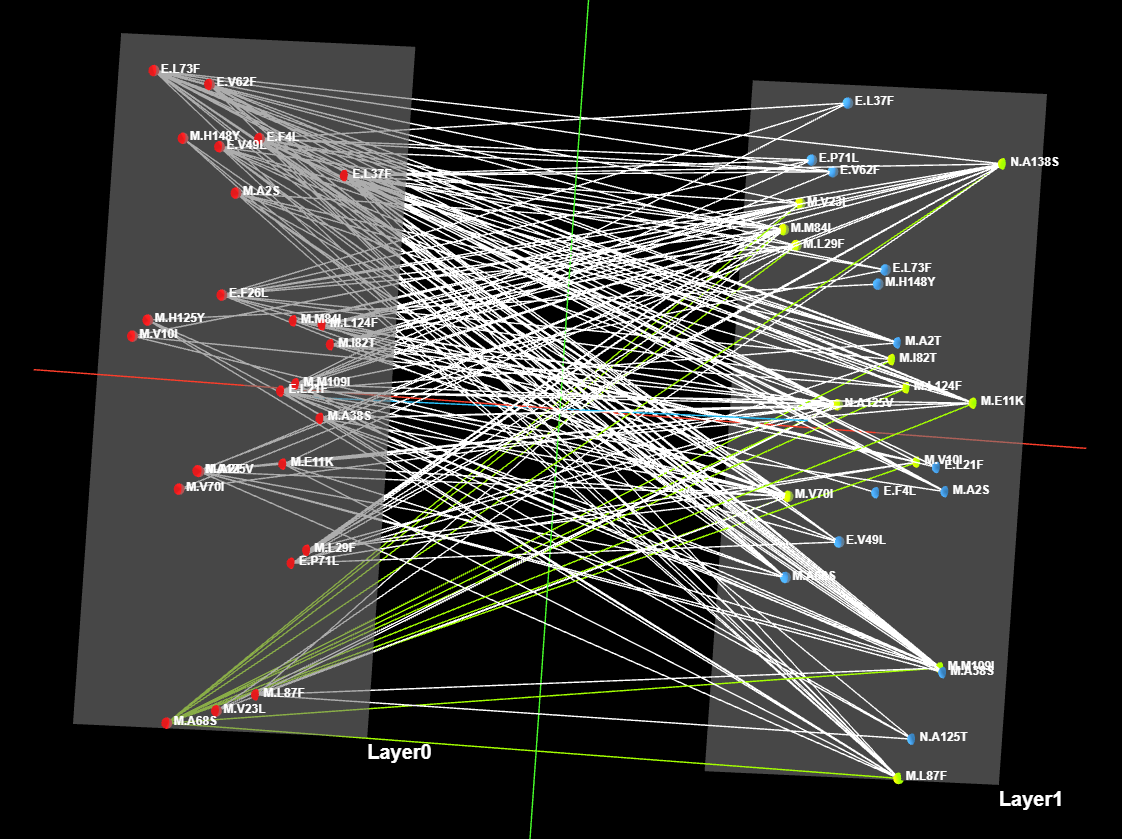

##Step 8: A-Priori Associations

Once I have found the pairs of similar mutations, for each clade, I search through the **A-Priori** algorithm for clusters of 3 mutations frequently associated with others four.

Since my aim is to identify among similar mutations in a clade those relationships that occur frequently, then the A-Priori algorithm is particularly well suited.

**A-Priori** is an association rule mining algorithm and is used to generate frequent itemsets, by successive approximations, starting from itemsets with a single element.

In summary, the theoretical assumption on which the algorithm is based starts from the consideration that if a set of objects is frequent, then all its subsets are also frequent, but if an itemset is not frequent then not even the sets that contain it are frequent. (anti-monotonicity).

In particular, if a subset is not frequent then all the supersets containing it will be eliminated (pruning).

Steps of the algorithm:

1. Initially I prepared the dataframes (one for each clade) on which to launch the apriori algorithm pre-implemented by the *mlxtent* library. This function takes as input a dataframe of Booleans in which each entry is true if the element is present in the transaction and false otherwise.

  So in my case I created, for each clade, a dataframe (square adjacency matrix) in which the rows and columns are the mutations present while an element aij is equal to 1 if there is an edge between the two mutations and 0 otherwise. If an edge exists it means that the two mutations are similar. So for each mutation the respective line tells me all the mutations to which this one is similar.

2. By running the a-priori algorithm on this matrix I find, for each clade, the clusters of mutations that are most frequently connected to each other. Of these sets I only consider those made up of **seven** mutations.

3. In this way I generated, through the *"association_rules"* function of the mlxtend module, the respective association rules composed of an **antecedent** part of **three mutations** and a **consequent** part of **4 mutations**.

Example:

> [N.I15T, N.I94V, N.I304V] => [N.I157T, N.H300R, N.G97C, N.I130V]

I saved the associacion rules in '/content/drive/MyDrive/BigData/a-priori/frequent_mut/'

Instead at this path '/content/drive/MyDrive/BigData/a-priori/7_frequent_mut/' there are the files containing the seven mutations groups.



In [ ]:
import pandas as pd
import csv
import numpy as np

# Create a new squared dataframe containing the present mutations in each clade as rows and columns.
# the matrix entries will be 0 or 1 depending on the presence/absence of an adge between the two considered mutations.

clades = ['19B', '20A', '20B', '20C', '20D', '20E(EU1)', '20G', '20I(Alpha,V1)', '20J(Gamma,V3)',
          '21A(Delta)', '21C(Epsilon)', '21F(Iota)', '21I(Delta)', '21J(Delta)', '21L(Omicron)']

for clade in clades:
  # read the present mutations in the clade
  mut_names_path = '/content/drive/MyDrive/BigData/similar_mutations/names/names_'+clade+'.txt'
  mut_names = []
  with open(mut_names_path, 'r')as r:
    lines = r.readlines()[0][1:-1].split(',')
    for mut in lines:
      mut_names.append(mut.strip()[1:-1])

  # load the graph edges
  df = pd.read_table('/content/drive/MyDrive/BigData/grafi/text/'+clade+'.tsv', sep='\t')
  n_edges = len(df)
  n_column = n_row = len(mut_names)

  mut_connection_matrix = np.zeros((n_row, n_column), dtype=int)

  mut_connection_df = pd.DataFrame(mut_connection_matrix, columns=mut_names, index=mut_names)

  # for each edge I take the two linked mutations and I change the value in the matrix to 1.
  for i in range(n_edges):
    # I take the couple of connected mutations
    sourceNode = df.loc[i]['SourceNode']
    targetNode = df.loc[i]['TargetNode']
    # I set their entry to 1
    mut_connection_df.at[sourceNode, targetNode]=1

  save_path = '/content/drive/MyDrive/BigData/a-priori/adj_matrix/'+clade+'.csv'
  mut_connection_df.to_csv(save_path, sep='\t')

Then I find the groups of 7 mutations more frequently connected to each other via the **A-Priori** algorithm.

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

#I run the algorithm on one variant at a time because I have to use different minsup thresholds
# depending on the different number of mutations and edges between them.
# Raising the threshold for the variants that contain more records and lowering otherwise. [0.2, 0.95]
clade = '21J(Delta)'
dataset = pd.read_table('/content/drive/MyDrive/BigData/a-priori/adj_matrix/'+clade+'.csv', sep='\t').iloc[:,1:]

frequent_itemsets = apriori(dataset, min_support=0.95, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets[ (frequent_itemsets['length'] == 7) ] # select only group of seven mutations

,support,itemsets,length
13259,0.951311,"(N.I130V, N.H300R, N.G97C, N.I94V, N.I157T, N....",7
13260,0.951311,"(N.H300R, N.G97C, N.I94V, N.I157T, N.I292V, N....",7
13261,0.951311,"(N.H300R, N.G97C, N.I94V, N.I157T, N.H145R, N....",7
13262,0.951311,"(N.H300R, N.G97C, N.I94V, N.I157T, N.I74T, N.I...",7
13263,0.951311,"(N.H300R, N.I74V, N.G97C, N.I94V, N.I157T, N.I...",7
...,...,...,...
20094,0.953184,"(N.I131M, N.I74V, N.H145R, N.K102R, N.I292V, N...",7
20095,0.951311,"(N.I131M, N.I130V, N.I74V, N.H145Y, N.H145R, N...",7
20096,0.956929,"(N.I131M, N.K127R, N.I130V, N.I74V, N.K102R, N...",7
20097,0.951311,"(N.I131M, N.I130V, N.I74V, N.H145R, N.G96V, N....",7


In [ ]:
#I saved the groups of seven mutations frequently connected in a file (one for each clade)

save_fr_itemsets = frequent_itemsets[ (frequent_itemsets['length'] == 7)].iloc[:, 1:-1]
save_fr_itemsets['itemsets'] = save_fr_itemsets['itemsets'].apply(list)

save_path = '/content/drive/MyDrive/BigData/a-priori/'+clade+'.csv'
save_fr_itemsets.to_csv(save_path, sep='\t')

I calculate the association rules of three mutations associated (similar) to others four and save them in a respective file.

In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules['antecedents_length'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequents_length'] = rules['consequents'].apply(lambda x: len(x))
rules.sort_values('lift', ascending=False)

# I select the association rules with three mutations as antecedent and four as consequents
rules = rules[(rules['antecedents_length'] == 3) & (rules['consequents_length'] == 4)].iloc[:,:-9]
rules['antecedents'] = rules['antecedents'].apply(list)
rules['consequents'] = rules['consequents'].apply(list)
rules

,antecedents,consequents
543799,"[N.I94V, N.I304V, N.I130V]","[N.I157T, N.H300R, N.I15T, N.G97C]"
543800,"[N.I157T, N.I94V, N.I304V]","[N.H300R, N.I15T, N.G97C, N.I130V]"
543801,"[N.H300R, N.I94V, N.I304V]","[N.I157T, N.I15T, N.G97C, N.I130V]"
543802,"[N.I15T, N.I94V, N.I304V]","[N.I157T, N.H300R, N.G97C, N.I130V]"
543803,"[N.G97C, N.I94V, N.I304V]","[N.I157T, N.H300R, N.I15T, N.I130V]"
...,...,...
1405543,"[N.K102R, N.I74V, N.I130V]","[N.I292V, N.H145R, N.I74T, N.I131M]"
1405544,"[N.I74T, N.I130V, N.I131M]","[N.I292V, N.H145R, N.K102R, N.I74V]"
1405545,"[N.I74V, N.I74T, N.I131M]","[N.I292V, N.H145R, N.K102R, N.I130V]"
1405546,"[N.I74V, N.I130V, N.I131M]","[N.I292V, N.H145R, N.I74T, N.K102R]"


In [ ]:
# I saved them
save_path = '/content/drive/MyDrive/BigData/a-priori/frequent_mut/'+clade+'.csv'
rules.to_csv(save_path, sep='\t')

##Step 9: Find the similar cluster using a Jaccard threshold of 0.75
Given the clusters of seven mutations frequently linked together, for each clade, I compare these sets considering differnt variants and return only those clusters whose Jaccard similarity is greater than or equal to 0.75.

The **Jaccard similarity** is an index that measures the similarity between two data sets and can vary from 0 to 1. The higher its value are(the closer it is to 1), more similar the two data sets are.

The Jaccard index is calculated as: **J(A,B) = |A∩B|/|A∪B|**

In [ ]:
import numpy as np

# I define the Jaccerd function

def jaccard_similarity(list1, list2):
  intersec = len(list(set(list1).intersection(list2)))
  union = (len(list1)+len(list2)) - intersec
  return float(intersec) / union

In [ ]:
# Definition of a function that takes two clade as input and after compares their mutations
# It return a csv file with all the similar mutations cluster of the two variants in input.
import csv

def find_cluster_sim(c1, c2, df_C1, df_C2):
  c1_itemset = df_C1['itemsets'].values
  c2_itemset = df_C2['itemsets'].values
  save_path = '/content/drive/MyDrive/BigData/results.csv'
  print(c1, '->', c2)
  with open(save_path, 'a')as w:
    writer = csv.writer(w)
    for i in range(len(c1_itemset)):
      c1_items_list = c1_itemset[i][1:-1].split(',')
      c1_str_mut = []
      for m in c1_items_list:
        c1_str_mut.append(m.strip()[1:-1])

      for j in range(len(c2_itemset)):
        c2_items_list = c2_itemset[j][1:-1].split(',')
        c2_str_mut = []
        for m in c2_items_list:
          c2_str_mut.append(m.strip()[1:-1])

        j_index = jaccard_similarity(c1_str_mut, c2_str_mut)
        if(j_index >= 0.75):
          data = [c1, c2, c1_str_mut, c2_str_mut, j_index]
          print(data)
          writer.writerow(data)

In [ ]:
import pandas as pd

# Run the function that computes the jaccard similarity on each clade.

clades = ['19A', '19B', '20A', '20B', '20C', '20D', '20E(EU1)', '20G', '20I(Alpha,V1)', '20J(Gamma,V3)',
          '21A(Delta)', '21C(Epsilon)', '21F(Iota)', '21I(Delta)', '21J(Delta)', '21K(Omicron)', '21L(Omicron)']

origin_path = '/content/drive/MyDrive/BigData/a-priori/7_frequent_mut/'
for i in range(len(clades)):
  C1_path = origin_path+clades[i]+'.csv'
  C1_df = pd.read_table(C1_path, sep='\t').iloc[:,1:]
  for j in range(len(clades)):
    if(i != j):
      C2_path = origin_path+clades[j]+'.csv'
      C2_df = pd.read_table(C2_path, sep='\t').iloc[:,1:]
      find_cluster_sim(clades[i], clades[j], C1_df, C2_df)

In [ ]:
# example of jaccard similarity computation on two cluster of mutations
a = ['N.A252S', 'N.A359S', 'N.A336V', 'N.A218S', 'N.A308S', 'N.A267V', 'N.A273S']
b = ['N.A313S', 'N.A308S', 'N.A359S', 'N.A336V', 'N.A273S', 'N.A267V', 'N.A252S']

jaccard_similarity(a,b)

0.75

The file "results.csv" contains the full results in the format:

[Clade 1, **Clade 2**, **C1_itemset**, **C2_itemset**, **jaccard_index**]

in which Clade1 and Clade 2 are the clades to which the similar clusters belong, C1_itemset and C2_itemset are the two clusters of seven mutations that pass the threshold and the last index is the Jaccard similarity calculated on the two clusters.

In total I found 13635 cases where clusters of similar mutations for different clades mutate together to generate the corresponding clade. This is the case for example of the variants:

- 20B e 20G
- 21I(Delta) e 20E(EU1)
- 20E(EU1) e 20C
- 20C e 20E(EU1)
- 20C e 21I(Delta)
- 21A(Delta) e 20J(Gamma, V3)
- 20J(Gamma, V3) e 21F(Iota)
- 21A(Delta) e 20G


In [ ]:
# Example of a resulting file.
import pandas as pd
result_path = '/content/drive/MyDrive/BigData/results.csv'
header = ['Clade 1', 'Clade 2', 'C1_itemset', 'C2_itemset', 'jaccard_index']
result_df = pd.read_table(result_path, sep=',', names=header, header=0)

result_df

,Clade 1,Clade 2,C1_itemset,C2_itemset,jaccard_index
0,20B,20G,"['N.A398S', 'N.A414V', 'N.D103Y', 'N.A55S', 'N...","['N.A55S', 'N.A90S', 'N.A414S', 'N.A398V', 'N....",0.75
1,20B,20G,"['N.A398S', 'N.A414V', 'N.D103Y', 'N.A55S', 'N...","['N.A55S', 'N.A414S', 'N.A398V', 'N.A90T', 'N....",0.75
2,20B,20G,"['N.A398S', 'N.A414V', 'N.D103Y', 'N.A55S', 'N...","['N.A55S', 'N.A414S', 'N.A35T', 'N.A398V', 'N....",0.75
3,20B,20G,"['N.A398S', 'N.A414V', 'N.D103Y', 'N.A55S', 'N...","['N.A55S', 'N.A414S', 'N.A398V', 'N.A90T', 'N....",0.75
4,20B,20G,"['N.A398S', 'N.A414V', 'N.D103Y', 'N.A55S', 'N...","['N.A381S', 'N.A55S', 'N.A414S', 'N.A398V', 'N...",0.75
...,...,...,...,...,...
13630,21I(Delta),20E(EU1),"['N.A252S', 'N.A359S', 'N.A336V', 'N.A218S', '...","['N.A308S', 'N.A359S', 'N.A336V', 'N.A273S', '...",0.75
13631,21I(Delta),20E(EU1),"['N.A252S', 'N.A359S', 'N.A336V', 'N.A218S', '...","['N.A359S', 'N.A308S', 'N.A336V', 'N.A273S', '...",0.75
13632,21I(Delta),20E(EU1),"['N.A252S', 'N.A359S', 'N.A336V', 'N.A218S', '...","['N.A359T', 'N.A359S', 'N.A308S', 'N.A336V', '...",0.75
13633,21I(Delta),20E(EU1),"['N.A252S', 'N.A359S', 'N.A336V', 'N.A218S', '...","['N.A359S', 'N.A308S', 'N.A336V', 'N.A273S', '...",0.75
